In [39]:
import os
import sys
py_files_dir = os.path.abspath("../../py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import itertools
import helper_functions as funcs
import instrument_matrices as matrices
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy_minimize_m3 as m3

# Setting Up Initial Instrument Parameters

In [40]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Load .csv files

In [41]:
csv_directory = '../../../data/unpolarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# Load data from all CSV files
all_data = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop = True, inplace = True)

# Plotting the Data in the HWP angle frame

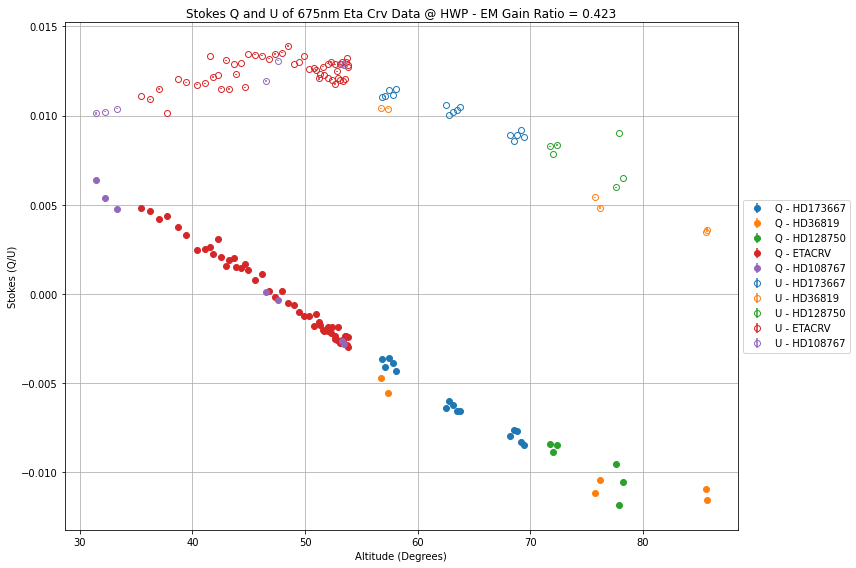

In [42]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # Calculate instrument matrix at HWP
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Plotting in the On-Sky Frame

Parallactic Angle: -84.9084509958819 Altitude: 56.56625 HWP Angle: 0.0 IMR Angle: 92.72502
Parallactic Angle: -84.92782440447132 Altitude: 56.6469 HWP Angle: 45.0 IMR Angle: 92.75622
Parallactic Angle: -84.94601513329397 Altitude: 56.72251 HWP Angle: 22.5 IMR Angle: 92.774
Parallactic Angle: -84.96558157041534 Altitude: 56.80395 HWP Angle: 67.5 IMR Angle: 92.83803
Parallactic Angle: -84.98557673519853 Altitude: 56.88694 HWP Angle: 0.0 IMR Angle: 92.88425
Parallactic Angle: -85.00475344133699 Altitude: 56.96644 HWP Angle: 45.0 IMR Angle: 92.9218
Parallactic Angle: -85.02352809078987 Altitude: 57.04475 HWP Angle: 22.5 IMR Angle: 92.96298
Parallactic Angle: -85.04303906901262 Altitude: 57.1258 HWP Angle: 67.5 IMR Angle: 93.00444
Parallactic Angle: -85.06352335313669 Altitude: 57.21077 HWP Angle: 0.0 IMR Angle: 93.04548
Parallactic Angle: -85.08298858276943 Altitude: 57.29144 HWP Angle: 45.0 IMR Angle: 93.07996
Parallactic Angle: -85.1012730269808 Altitude: 57.36742 HWP Angle: 22.5 IMR Ang

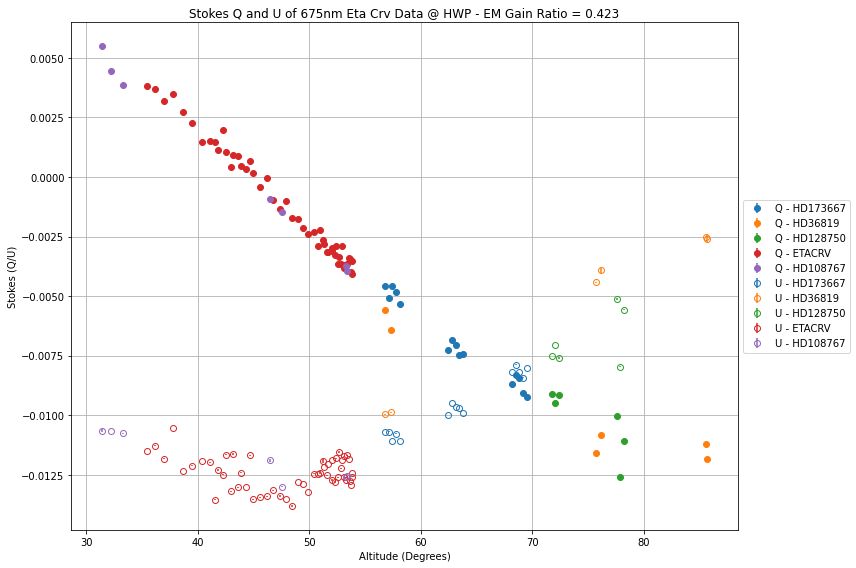

In [48]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            print("Parallactic Angle: " + str(parang) + " Altitude: " + str(altitude) + " HWP Angle: " + str(HWP_ang) + " IMR Angle: " + str(IMR_ang))

            # Calculate instrument matrix for equatorial reference frame
            # these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            # Calculate instrument matrix at HWP
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Plotting Forward Model

Best Fit M3 Diattenuation: 0.012448240679962228
Best Fit Offset: -2.5205866232499186


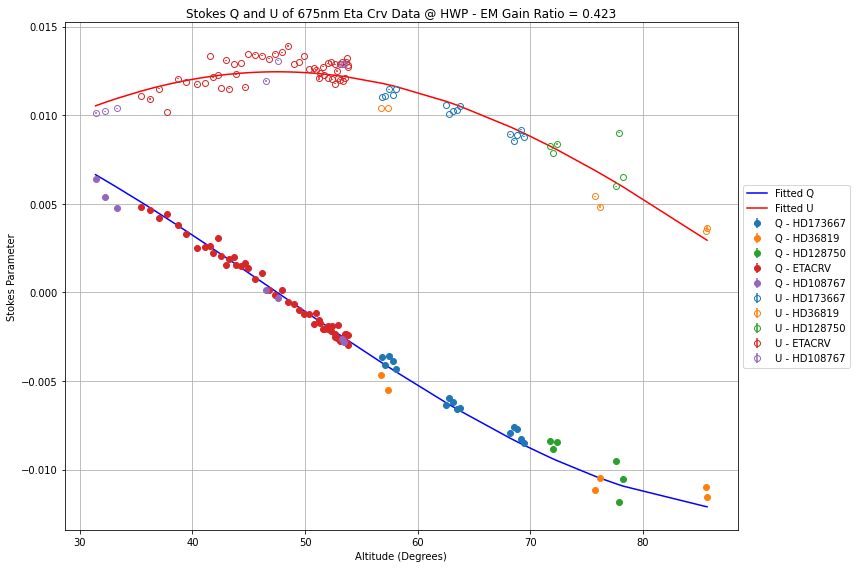

In [44]:
# Extract altitudes, Q_data, and U_data from the previous block of code
altitudes = [item[0] for item in Q_list]  # Extracting altitudes from Q_list (they are the same for U_list)
Q_data = np.array([item[1] for item in Q_list]).flatten()
U_data = np.array([item[1] for item in U_list]).flatten()

# Initial guesses for delta_m3, epsilon_m3, and offset
initial_guesses = [0, 0.01, 1]
bounds = [(0, 1), (-0.5, 0.5), (-10, 10)]

# Perform the minimization using Nelder-Mead with bounds
result = minimize(m3.residuals, initial_guesses, args=(altitudes, Q_data, U_data), method='Nelder-Mead', bounds=bounds)

# Extract the best-fit parameters
delta_m3_best, epsilon_m3_best, offset_best = result.x

print("Best Fit M3 Diattenuation: " + str(epsilon_m3_best))
print("Best Fit Offset: " + str(offset_best))

# Calculate the fitted Q and U values
Q_fitted, U_fitted = m3.propagate_unpol_source(delta_m3_best, epsilon_m3_best, offset_best, altitudes)
# Q_fitted, U_fitted = m3.propagate_unpol_source(0, 0.0125, -2.5, altitudes)

# Sort the fitted values by altitude
sorted_indices = np.argsort(altitudes)
altitudes_sorted = np.array(altitudes)[sorted_indices]
Q_fitted_sorted = Q_fitted[sorted_indices]
U_fitted_sorted = U_fitted[sorted_indices]

# Plotting the data and the fitted line
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

# Plot the fitted line with different colors for Q and U
plt.plot(altitudes_sorted, Q_fitted_sorted, label='Fitted Q', linestyle='-', color='blue')
plt.plot(altitudes_sorted, U_fitted_sorted, label='Fitted U', linestyle='-', color='red')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes Parameter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Matrix Inversion for On-Sky Frame of Reference

In [45]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0.5 # (waves) - assumed to be zero for now
epsilon_m3 = 0.01244  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

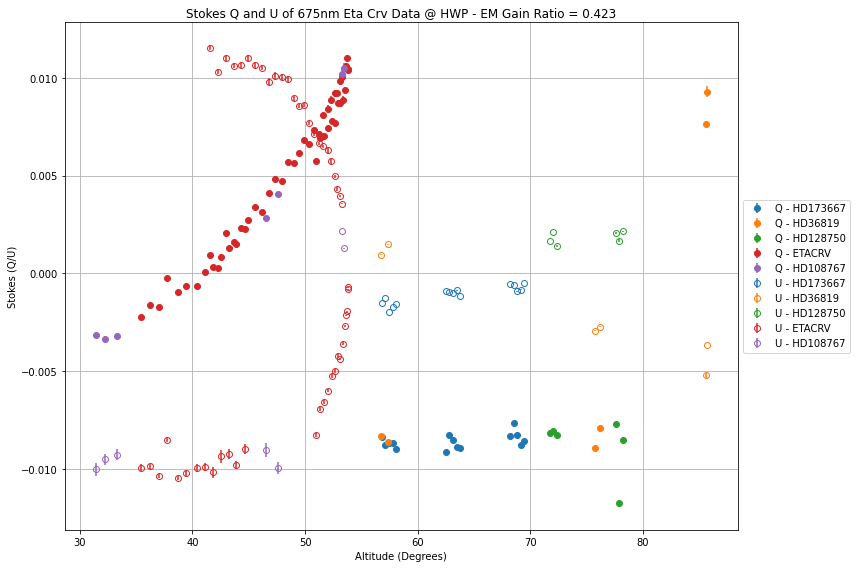

In [46]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # Calculate instrument matrix at HWP
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            # double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
